celebahq
* mean = [0.5157, 0.4160, 0.3625]
* std = [0.3005, 0.2712, 0.2657]

ffhq
* mean = [0.5189, 0.4236, 0.3797]
* std = [0.2820, 0.2550, 0.2557]

celebahq_gamma_1.5_1.7
* mean = [0.0806, 0.0599, 0.0506]
* std = [0.0789, 0.0663, 0.0623]

ffhq_gamma_1.5_1.7
* mean = [0.0785, 0.0590, 0.0518]
* std = [0.0750, 0.0634, 0.0611]

In [42]:
from pathlib import Path
from PIL import Image
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import torch
import torchvision.transforms as T

# hr_path = '/home/allen/Documents/MIE288/sr3_server4/data/dark/ffhq_256_256_gamma_1.5_1.7/hr'
# lr_path = '/home/allen/Documents/MIE288/sr3_server4/data/dark/ffhq_256_256_gamma_1.5_1.7/lr'
# hiseq_path = '/home/allen/Documents/MIE288/sr3_server4/data/dark/ffhq_256_256_gamma_1.5_1.7/hiseq'

hr_path = '/home/allen/Documents/MIE288/sr3_server4/data/dark/celebahq_256_256_gamma_1.5_1.7/hr'
lr_path = '/home/allen/Documents/MIE288/sr3_server4/data/dark/celebahq_256_256_gamma_1.5_1.7/lr'
hiseq_path = '/home/allen/Documents/MIE288/sr3_server4/data/dark/celebahq_256_256_gamma_1.5_1.7/hiseq'

hr_files = [p for p in Path('{}'.format(hr_path)).glob(f'**/*')]
hr_files=sorted(hr_files, key=lambda i: int(i.stem))

lr_files = [p for p in Path('{}'.format(lr_path)).glob(f'**/*')]
lr_files=sorted(lr_files, key=lambda i: int(i.stem))

hiseq_files = [p for p in Path('{}'.format(hiseq_path)).glob(f'**/*')]
hiseq_files=sorted(hiseq_files, key=lambda i: int(i.stem))

In [44]:
mean_hr = [0, 0, 0]
std_hr = [1, 1, 1]

mean_lr = [0, 0, 0]
std_lr = [1, 1, 1]

transform_hr = T.Compose([
    T.ToTensor(),
    T.Normalize(mean_hr, std_hr)
])

transform_lr = T.Compose([
    T.ToTensor(),
    T.Normalize(mean_lr, std_lr)
])

In [45]:
def to_tensor_and_normalize(files, mode):
    img_ls = []

    for file in tqdm(files):
        img = Image.open(file).convert('RGB')
        if mode == 'HR':
            img = transform_hr(img)
        else:
            img = transform_lr(img)
        img_ls.append(img)
    
    img_ls = torch.stack(img_ls, 0)

    return img_ls

In [46]:
hr_imgs = to_tensor_and_normalize(hr_files, 'HR')
lr_imgs = to_tensor_and_normalize(lr_files, 'LR')
hiseq_imgs = to_tensor_and_normalize(hiseq_files, 'LR')

100%|██████████| 30000/30000 [01:24<00:00, 353.74it/s]


In [47]:
def find_y_avg(imgs):
    y_list = []
    
    for i in tqdm(range(imgs.shape[0])):
        y = 0.299*imgs[i,0,:,:] + 0.587*imgs[i,1,:,:] + 0.114*imgs[i,2,:,:]
        y_avg = np.average(y)
        y_list.append(y_avg)
    
    return np.array(y_list)

In [48]:
def calculate_mean_std(imgs):

    mean_ls = []
    std_ls = []
    
    channels = imgs.shape[1]

    for i in tqdm(range(channels)):
        all_pixels = imgs[:,i,:,:]
        
        std, mean = torch.std_mean(all_pixels)

        mean_ls.append(mean.item())
        std_ls.append(std.item())
    
    return mean_ls, std_ls
    

In [49]:
mean_hr, std_hr = calculate_mean_std(hr_imgs)
print(mean_hr)
print(std_hr)

mean_lr, std_lr = calculate_mean_std(lr_imgs)
print(mean_lr)
print(std_lr)

mean_hiseq, std_hiseq = calculate_mean_std(hiseq_imgs)
print(mean_hiseq)
print(std_hiseq)

100%|██████████| 3/3 [00:04<00:00,  1.40s/it]


[0.5171085596084595, 0.4166611135005951, 0.3634870648384094]
[0.30106019973754883, 0.2723495662212372, 0.26739370822906494]


100%|██████████| 3/3 [00:04<00:00,  1.39s/it]


[0.08092497289180756, 0.06012996658682823, 0.050999607890844345]
[0.07921801507472992, 0.06673561781644821, 0.06303226947784424]


100%|██████████| 3/3 [00:03<00:00,  1.04s/it]

[0.47571495175361633, 0.46652695536613464, 0.457474946975708]
[0.30860862135887146, 0.3171645402908325, 0.3253151774406433]


In [50]:
hr_y = find_y_avg(hr_imgs)
lr_y = find_y_avg(lr_imgs)
hiseq_y = find_y_avg(hiseq_imgs)

100%|██████████| 30000/30000 [00:15<00:00, 1981.08it/s]


In [52]:
hr_sample = hr_imgs[0].permute(1,2,0).numpy()
lr_sample = lr_imgs[0].permute(1,2,0).numpy()
hiseq_sample = hiseq_imgs[0].permute(1,2,0).numpy()

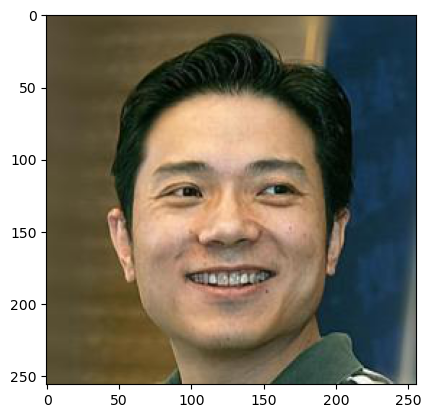

In [53]:
plt.imshow(hr_sample)

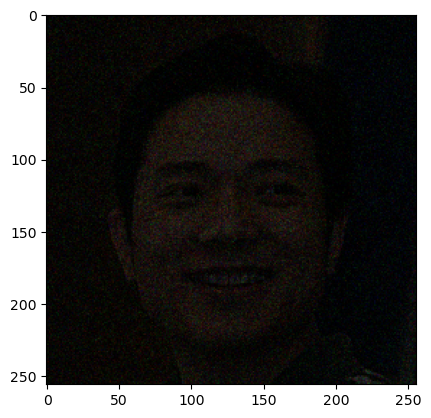

In [54]:
plt.imshow(lr_sample)

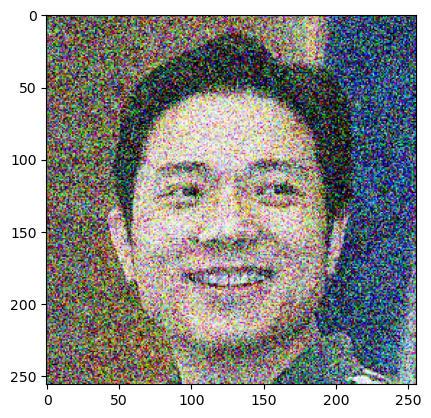

In [55]:
plt.imshow(hiseq_sample)

Text(0.5, 1.0, 'Y distribution of HR imgs')

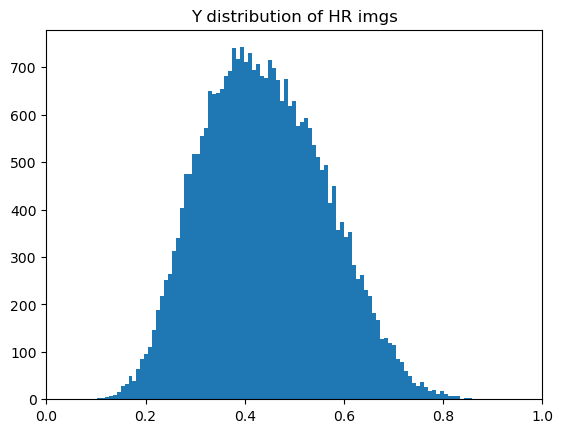

In [58]:
plt.hist(hr_y, bins=100)
plt.xlim(0, 1)
plt.title('Y distribution of HR imgs')


Text(0.5, 1.0, 'Y distribution of LR imgs')

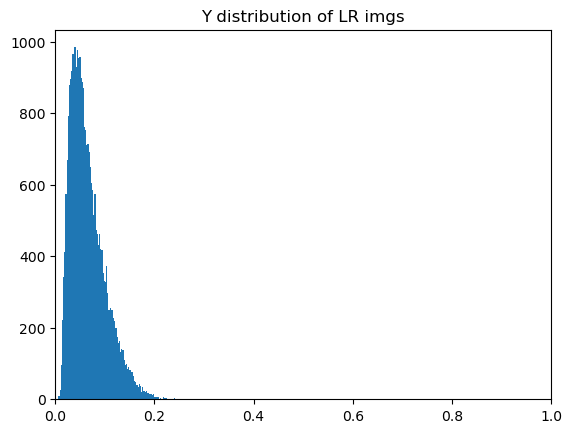

In [59]:
plt.hist(lr_y, bins=100)
plt.xlim(0, 1)
plt.title('Y distribution of LR imgs')

Text(0.5, 1.0, 'Y distribution of LR imgs')

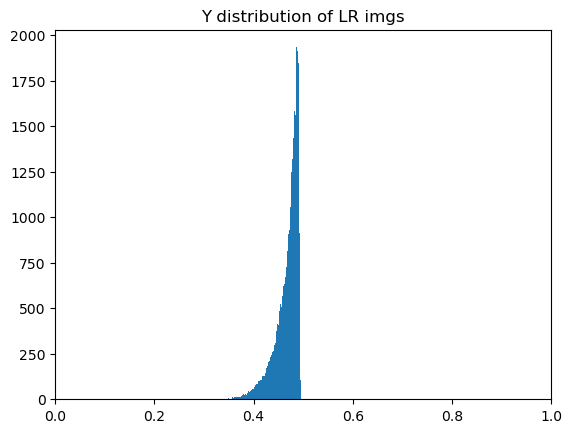

In [60]:
plt.hist(hiseq_y, bins=100)
plt.xlim(0, 1)
plt.title('Y distribution of LR imgs')